In [31]:
!pip install seaborn


In [32]:
!pip install scikit-learn


In [33]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F



%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [34]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT



C:\Python312\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: c:\Users\Plugify\Documents\pessoal\faculdade\Tópicos\git\LSTM-Autoencoders\ECG5000.zip

  0%|          | 0.00/10.6M [00:00<?, ?B/s]
  5%|▍         | 524k/10.6M [00:00<00:06, 1.60MB/s]
 10%|▉         | 1.05M/10.6M [00:00<00:06, 1.49MB/s]
 15%|█▍        | 1.57M/10.6M [00:00<00:04, 1.81MB/s]
 20%|█▉        | 2.10M/10.6M [00:01<00:04, 1.75MB/s]
 25%|██▍       | 2.62M/10.6M [00:01<00:04, 1.64MB/s]
 30%|██▉       | 3.15M/10.6M [00:01<00:04, 1.62MB/s]
 35%|███▍      | 3.67M/10.6M [00:02<00:04, 1.72MB/s]
 40%|███▉      | 4.19M/10.6M [00:02<00:03, 1.85MB/s]
 44%|████▍     | 4.72M/10.6M [00:02<00:03, 1.82MB/s]
 49%|████▉     | 5.24M/10.6M [00:02<00:02, 1.86MB/s]
 54%|█████▍    | 5.77M/10.6M [00:03<0

In [45]:
import zipfile
import os

# Caminho para o arquivo zip
zip_file_path = 'ECG5000.zip'  # Altere para o caminho correto se necessário
# Diretório de destino onde os arquivos serão extraídos
extraction_path = 'ECG5000_extracted'  # Nome da pasta para extração

# Cria o diretório de extração se não existir
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Descompacta o arquivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f'Arquivo descompactado em: {extraction_path}')


Arquivo descompactado em: ECG5000_extracted


In [46]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
import pandas as pd
from scipy.io import arff

# Carregar os dados de treino
train_data = arff.loadarff('ECG5000_extracted/ECG5000_TRAIN.arff')
train = pd.DataFrame(train_data[0])  # Converte para DataFrame

# Carregar os dados de teste
test_data = arff.loadarff('ECG5000_extracted/ECG5000_TEST.arff')
test = pd.DataFrame(test_data[0])  # Converte para DataFrame

# Junta os DataFrames de treino e teste
df = pd.concat([train, test])

# Embaralha as linhas do DataFrame
df = df.sample(frac=1.0)

# Exibe a forma do DataFrame
print(df.shape)  # Deve exibir (5000, 141) se tudo estiver correto


(5000, 141)


In [58]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
578,0.014455,-2.329438,-4.055291,-4.373864,-4.236482,-3.714663,-2.376811,-1.754589,-1.455006,-0.701647,...,0.409913,0.458103,0.784294,0.753175,0.573727,0.548756,0.955694,1.667319,-0.137907,b'1'
2389,-0.183241,-2.799339,-3.977663,-4.655555,-4.240888,-2.854785,-1.834706,-1.741318,-0.706689,-0.093868,...,1.300421,2.150561,1.831271,1.375666,0.837915,0.673730,0.177985,0.725047,0.899939,b'1'
1803,-1.391155,-3.653796,-4.175486,-4.378780,-3.370858,-2.330518,-1.780016,-1.318189,-0.451626,-0.403178,...,1.191089,1.322139,1.115013,0.695885,0.338318,0.306634,0.301472,1.349169,0.227880,b'1'
1801,-0.533990,-3.147629,-3.853210,-4.275581,-4.229231,-3.317245,-2.097495,-1.448345,-1.216390,-0.374337,...,0.525625,0.751582,0.926297,0.815278,0.486851,0.582640,0.845928,1.238261,-1.302150,b'1'
107,-1.060127,-2.723479,-3.083435,-3.955569,-4.118897,-3.775926,-2.344364,-1.381871,-1.114123,-0.496219,...,1.304620,0.782370,-0.069595,-0.764278,-1.472368,-1.375166,-0.917934,-0.492686,-1.240433,b'1'


In [60]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [61]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.target.value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

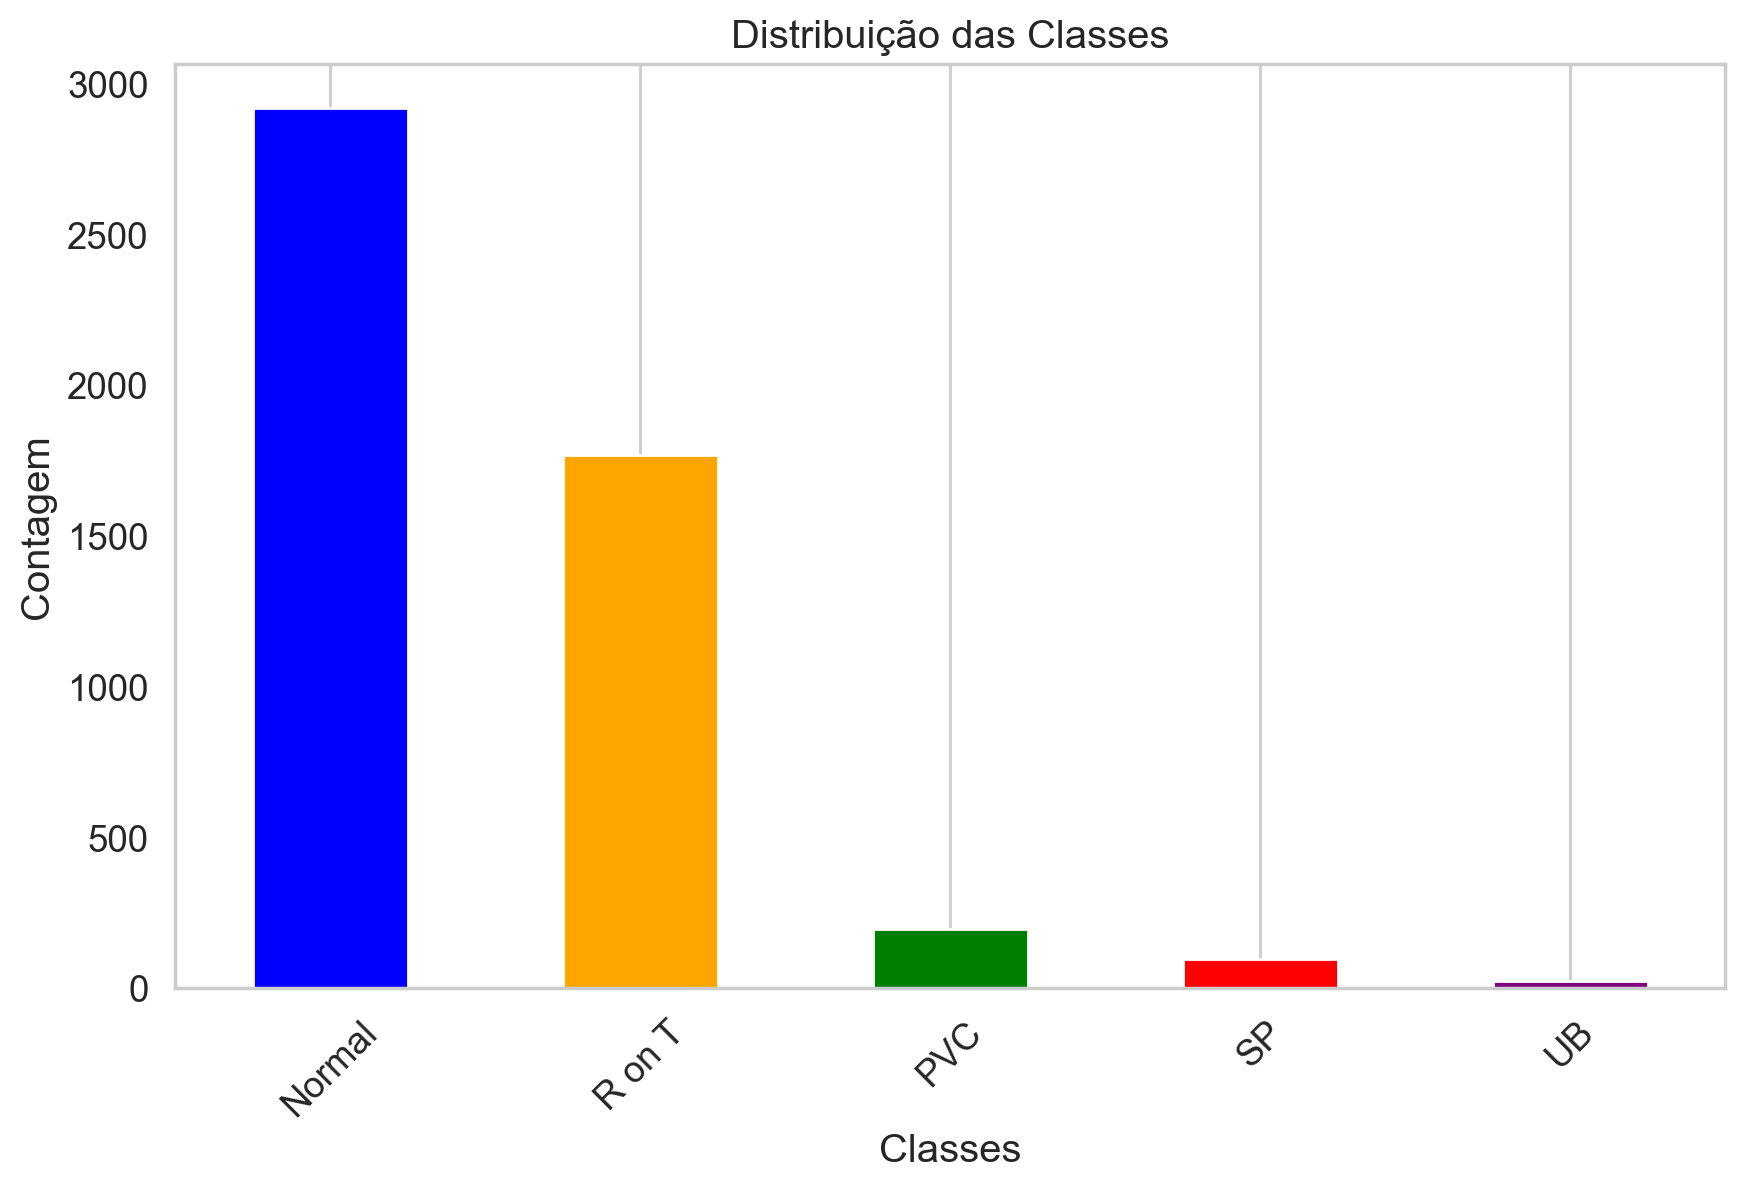

In [62]:
import matplotlib.pyplot as plt

# Contar as ocorrências de cada classe na coluna target
class_counts = df.target.value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple']
class_counts.plot(kind='bar', color=colors)

plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

plt.title('Distribuição das Classes')
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [63]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = df.target.value_counts()


  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

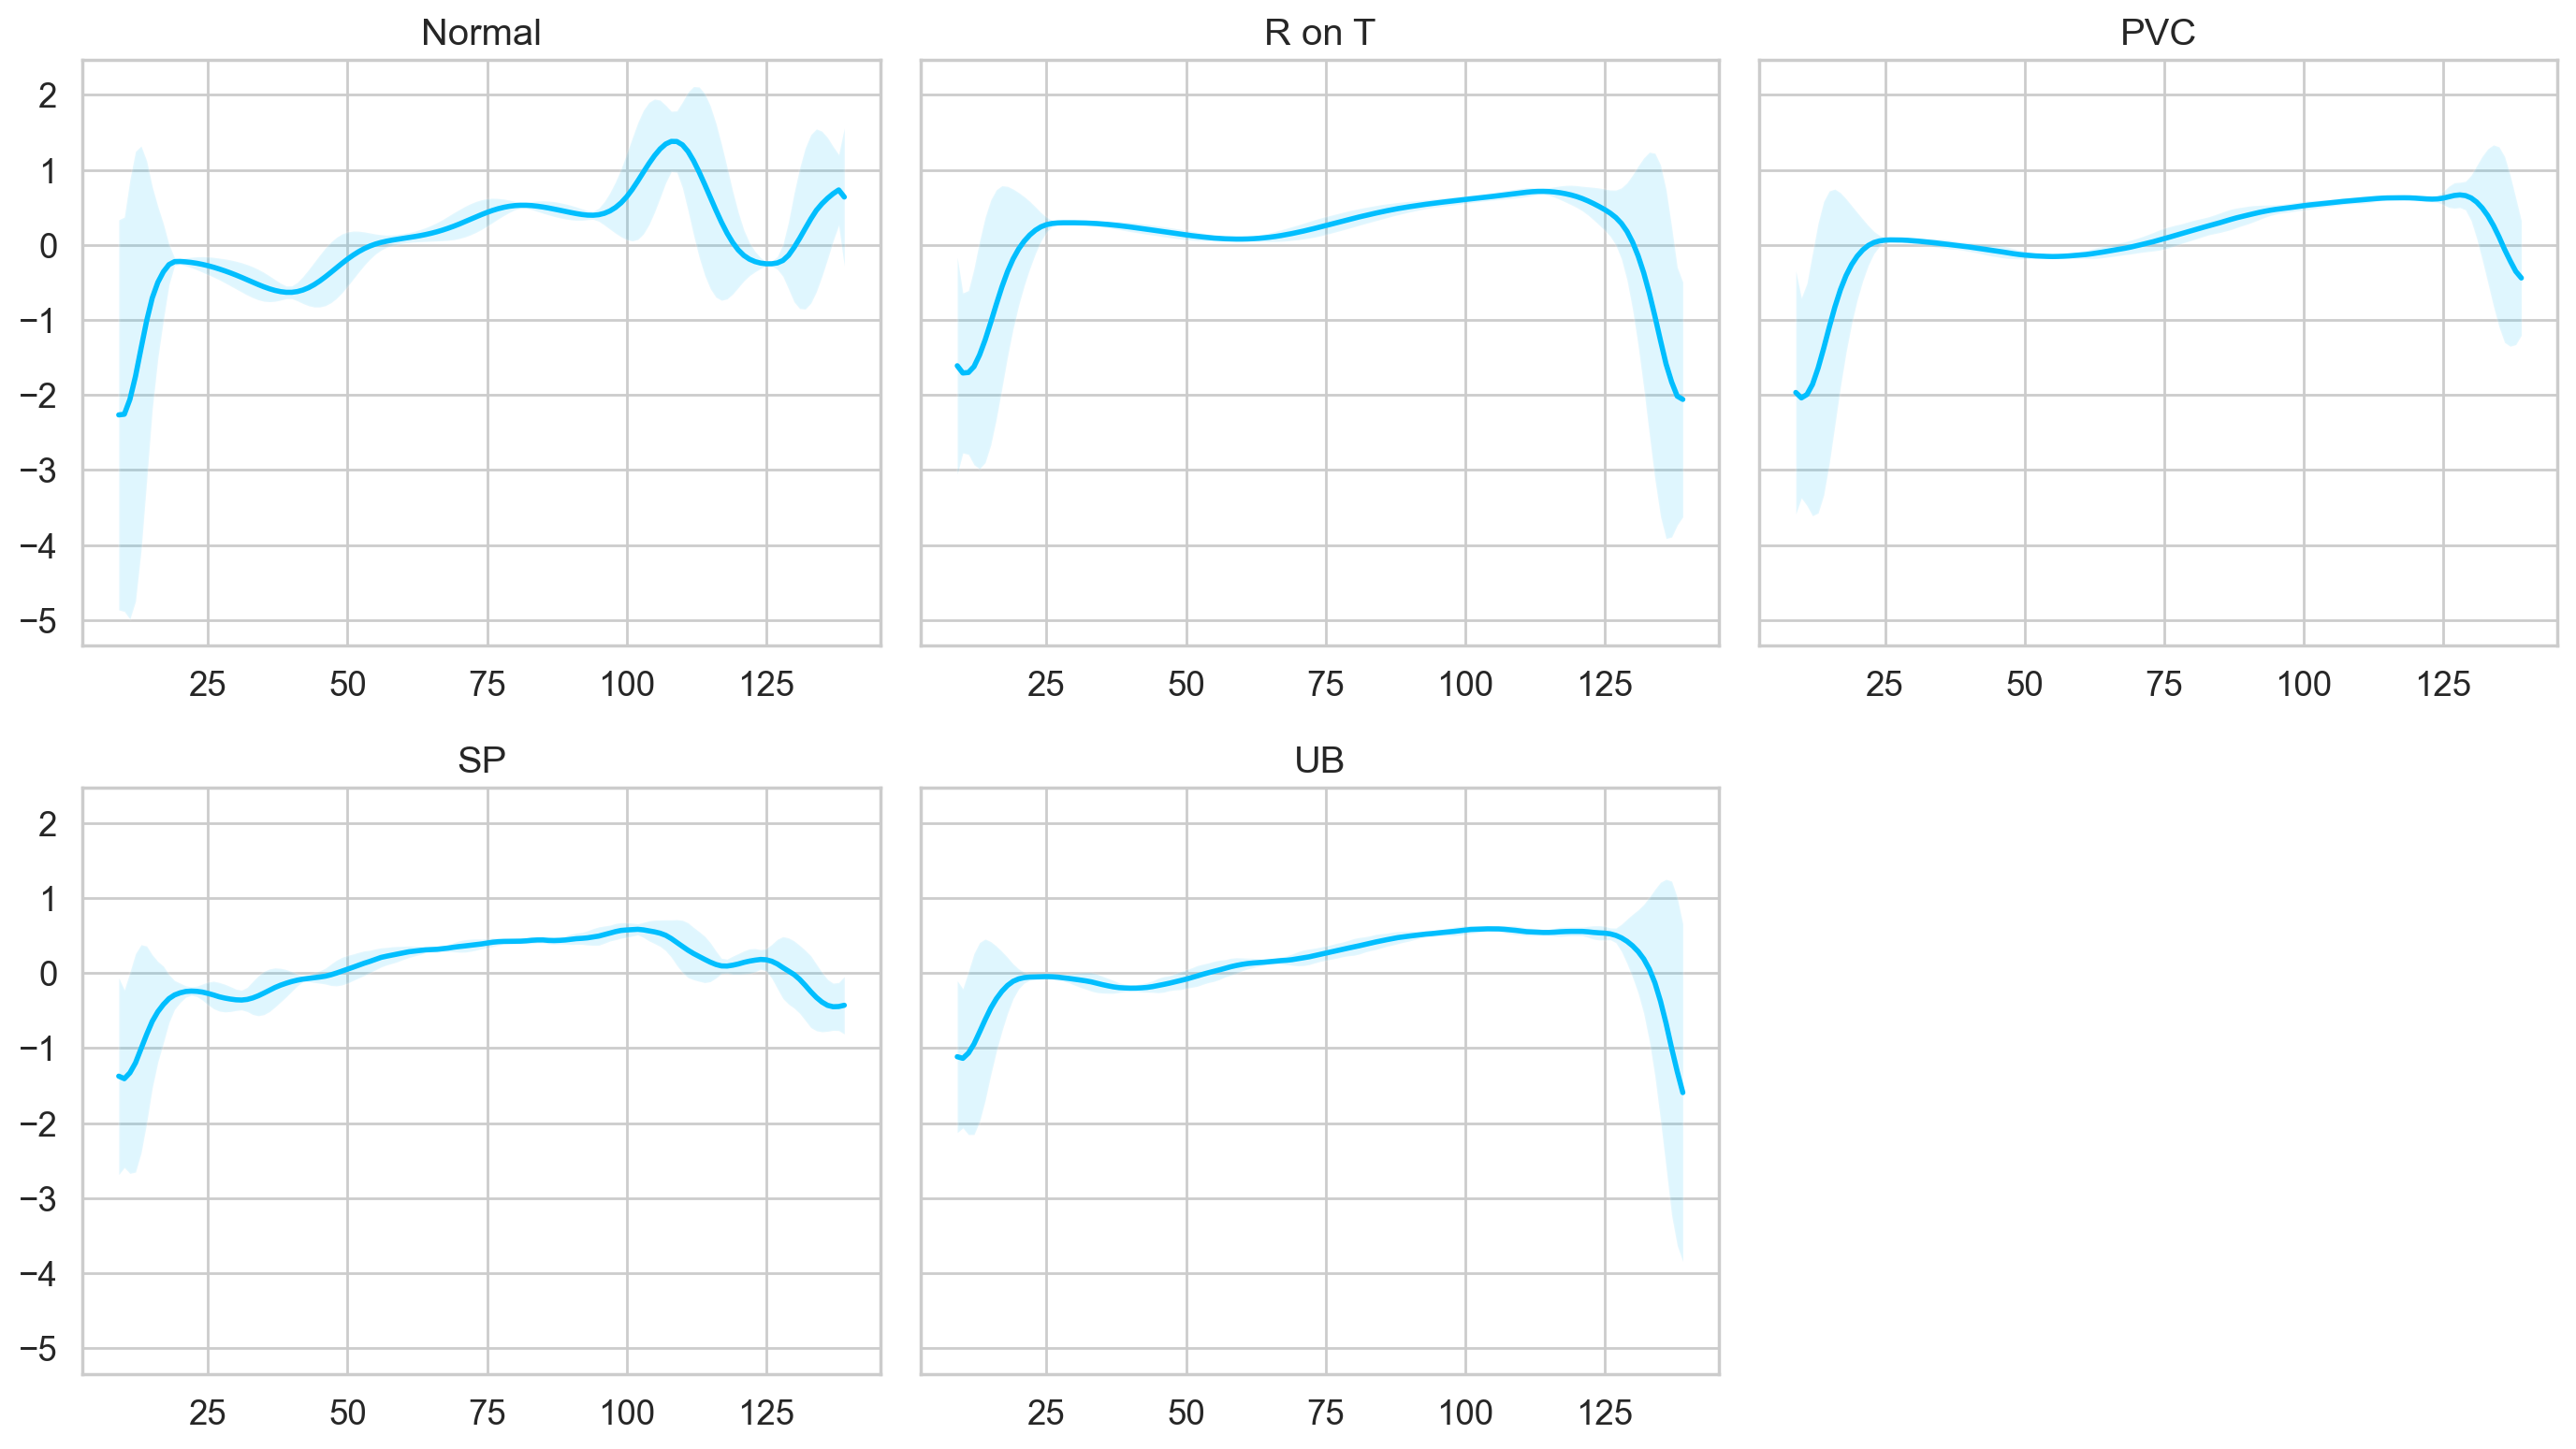

In [64]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)
     

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()
     

In [65]:
normal_df = df[df['target'].apply(lambda x: x.decode('utf-8')) == str(CLASS_NORMAL)].drop(labels='target', axis=1)
print(normal_df.shape)

(2919, 140)


In [70]:
anomaly_df = df[df['target'].apply(lambda x: x.decode('utf-8')) != str(CLASS_NORMAL)].drop(labels='target', axis=1)
print(anomaly_df.shape)


(2081, 140)


In [71]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [72]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [73]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [74]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [75]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [76]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [77]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [78]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [80]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=20
)

Epoch 1: train loss 18.638619426564315 val loss 22.7518086612428
Epoch 2: train loss 18.118104066352892 val loss 16.73676501199247
Epoch 3: train loss 18.109337905297977 val loss 18.447700786916062
Epoch 4: train loss 17.341448596676045 val loss 16.286741115127406
Epoch 5: train loss 17.015493224965425 val loss 15.972030034244264
Epoch 6: train loss 17.30238828136286 val loss 15.732232822899933
Epoch 7: train loss 16.918172436344772 val loss 17.013127196770885
Epoch 8: train loss 16.734608529508716 val loss 15.870985503082796
Epoch 9: train loss 16.385240844448262 val loss 15.204463753683982
Epoch 10: train loss 16.21579363037626 val loss 17.302274560765603
Epoch 11: train loss 16.198606494740584 val loss 15.4250041795672
Epoch 12: train loss 15.97731762189915 val loss 16.319477722506473
Epoch 13: train loss 15.929174653660237 val loss 15.214817006433377
Epoch 14: train loss 15.777635421353162 val loss 15.577068419993534
Epoch 15: train loss 15.517460636437203 val loss 14.4301460008979

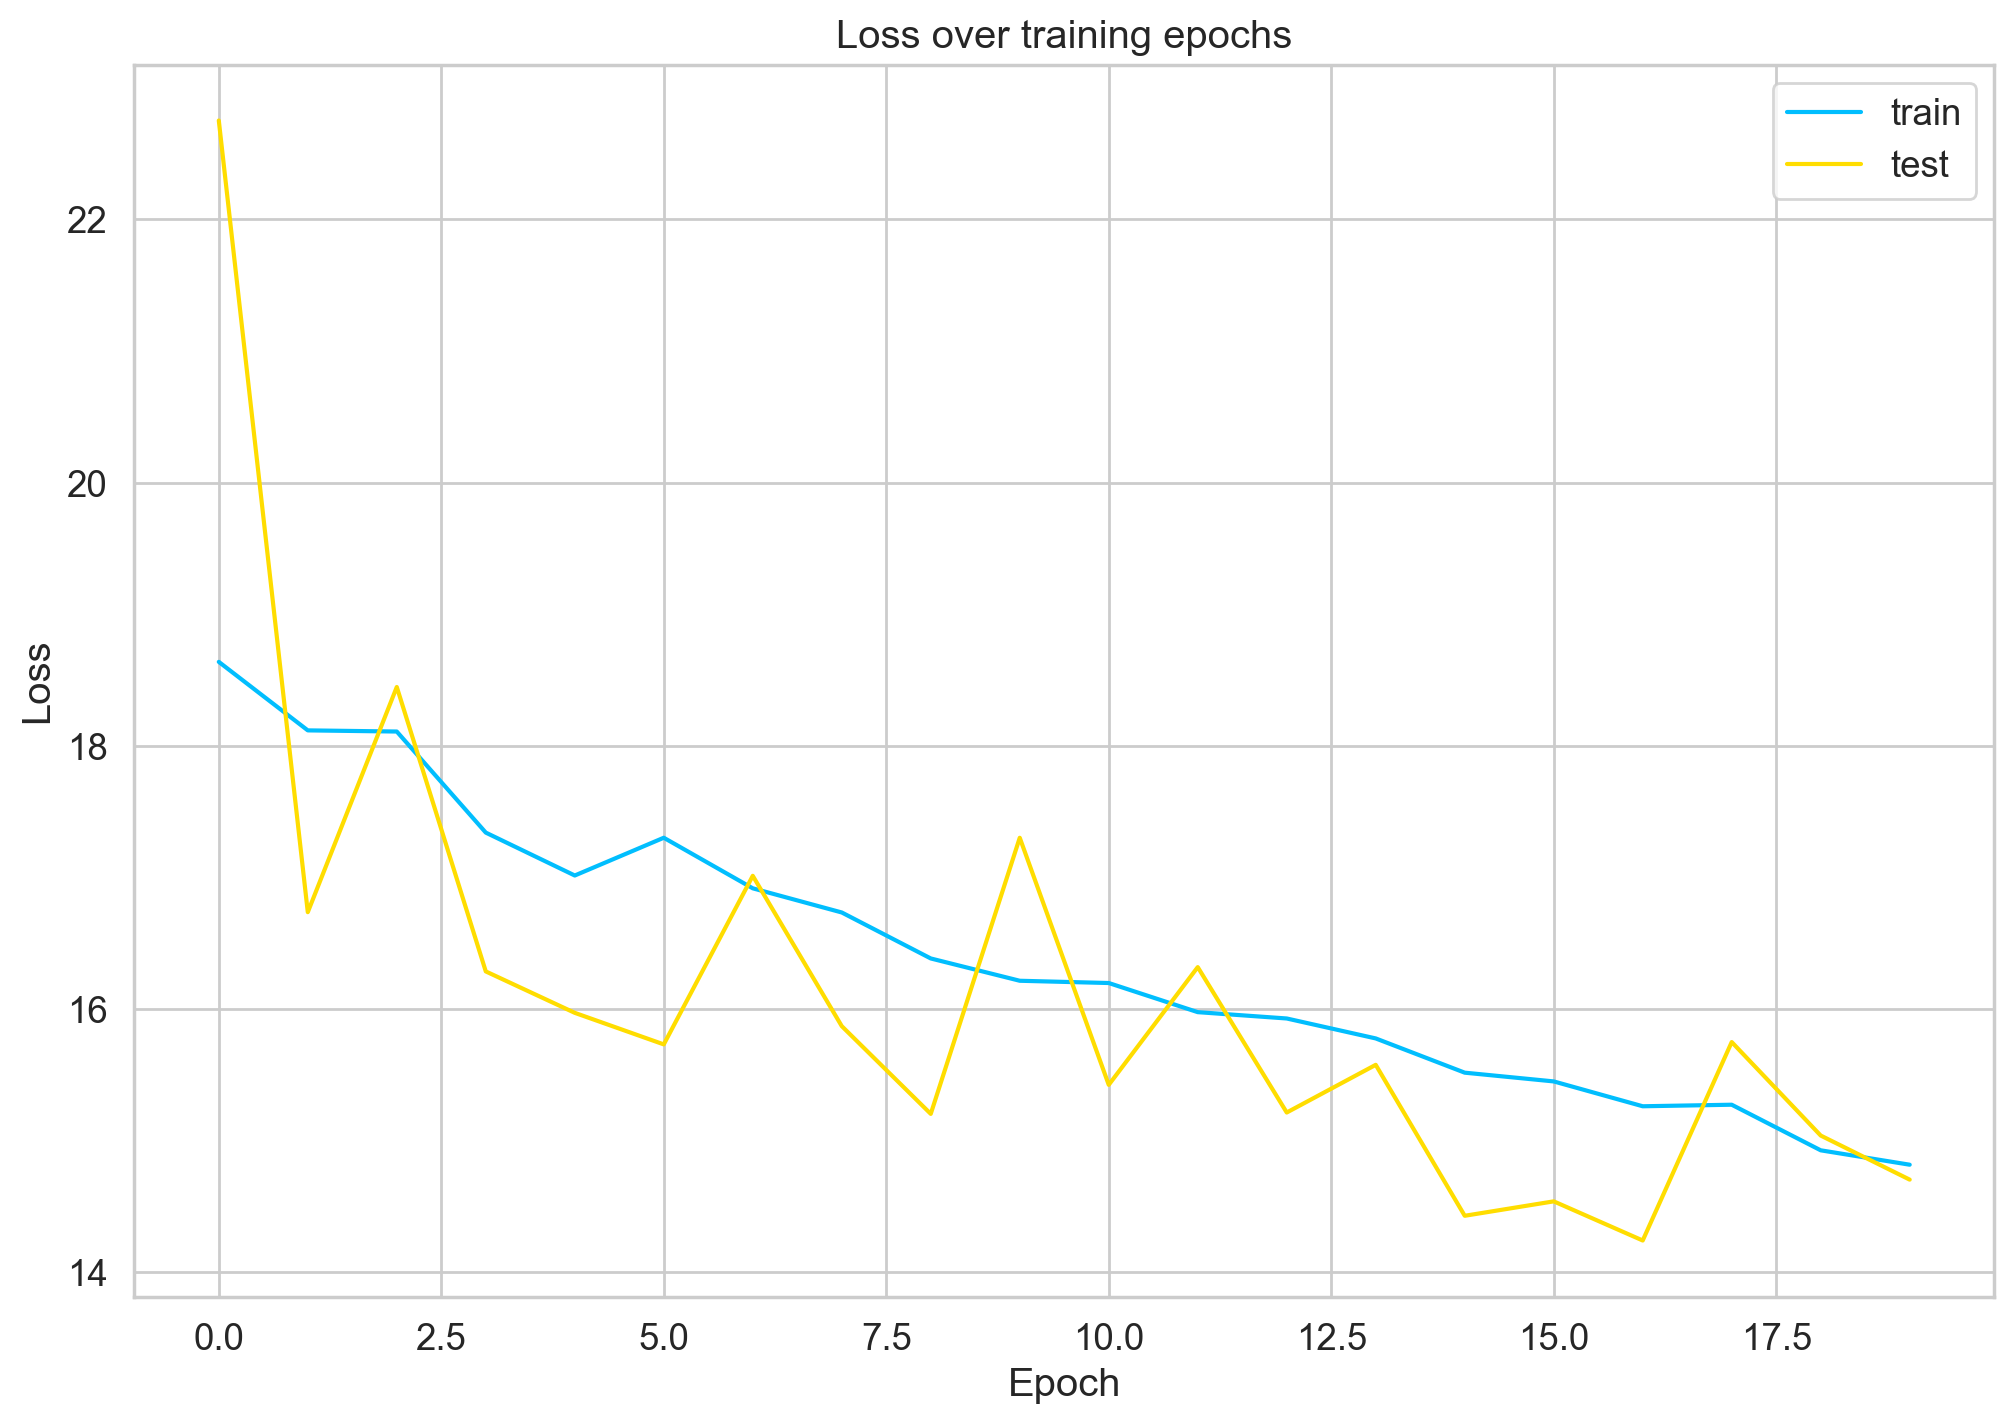

In [81]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [82]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [85]:
!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A

C:\Python312\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: c:\Users\Plugify\Documents\pessoal\faculdade\Tópicos\git\LSTM-Autoencoders\model.pth

  0%|          | 0.00/3.98M [00:00<?, ?B/s]
 13%|█▎        | 524k/3.98M [00:00<00:03, 1.00MB/s]
 26%|██▋       | 1.05M/3.98M [00:00<00:01, 1.83MB/s]
 40%|███▉      | 1.57M/3.98M [00:00<00:01, 2.27MB/s]
 53%|█████▎    | 2.10M/3.98M [00:00<00:00, 2.46MB/s]
 66%|██████▌   | 2.62M/3.98M [00:01<00:00, 2.95MB/s]
 79%|███████▉  | 3.15M/3.98M [00:01<00:00, 3.10MB/s]
 92%|█████████▏| 3.67M/3.98M [00:01<00:00, 2.91MB/s]
100%|██████████| 3.98M/3.98M [00:01<00:00, 2.61MB/s]


In [86]:
# Carregar o modelo mapeado para a CPU
model = torch.load('model.pth', map_location=torch.device('cpu'))

# Se você estiver treinando ou usando o modelo na CPU
model = model.to(torch.device('cpu'))

C:\Users\Plugify\AppData\Local\Temp\ipykernel_17220\3927218418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth', map_location=torch.device(

In [87]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

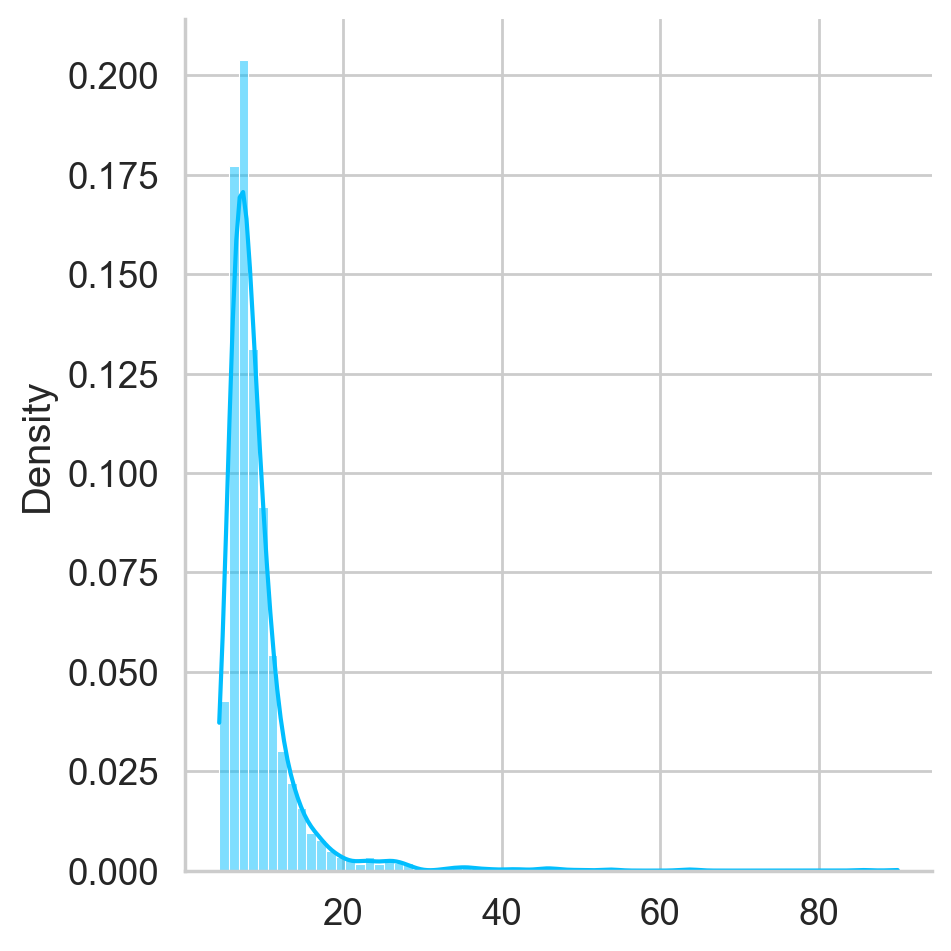

In [92]:
_, losses = predict(model, train_dataset)

# Ajustando a normalização para densidade (estatística)
sns.displot(losses, bins=70, kde=True, stat="density")

In [93]:
THRESHOLD = 26

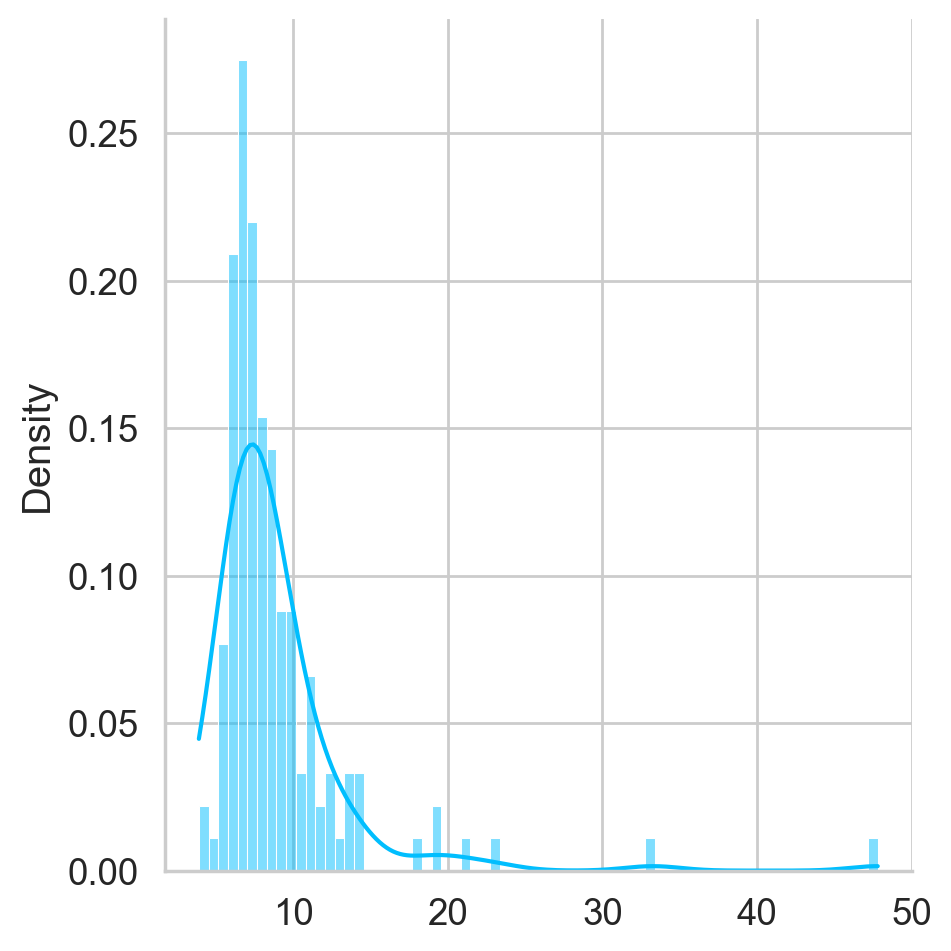

In [102]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.displot(pred_losses, bins=70, kde=True, stat="density")

In [103]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 143/145


In [104]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

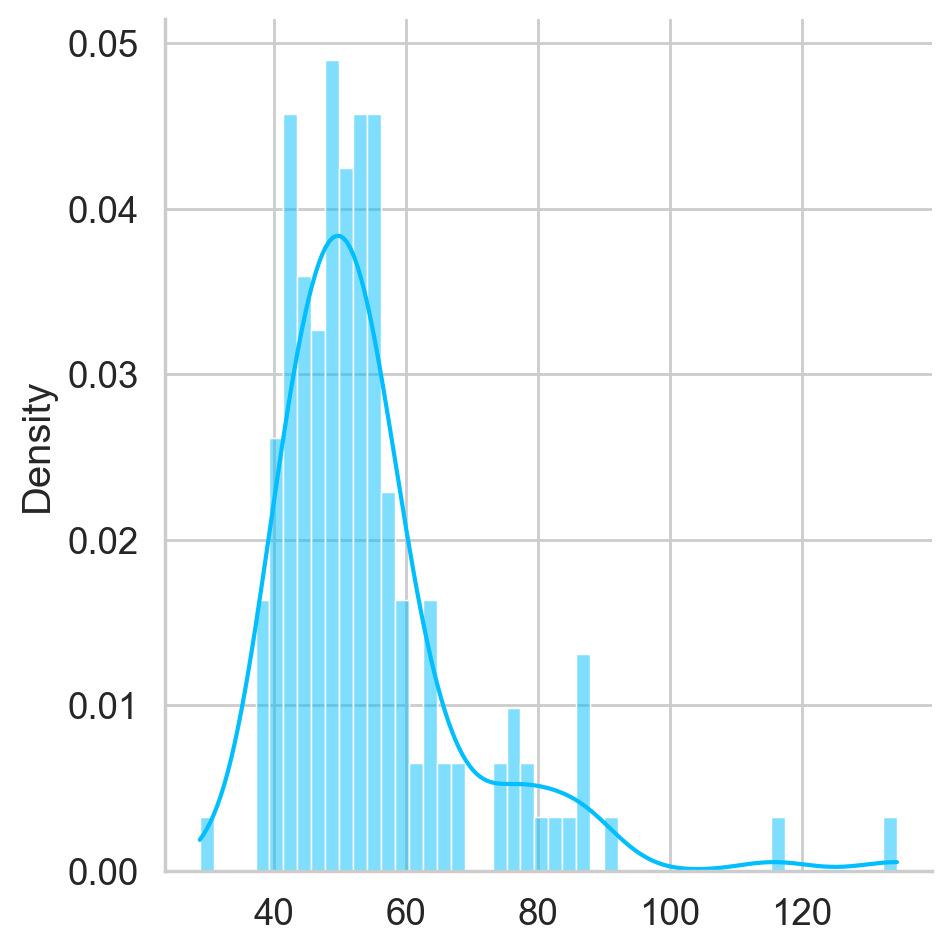

In [107]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.displot(pred_losses, bins=50, kde=True, stat="density")